<a href="https://colab.research.google.com/github/MattIzon/16010269_DataAnalytics/blob/main/DNN/Model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DNN Model 4 No District Separation

Predictors Removed:
*   date
*   gust
*   hail
*   tornado_funnel_cloud




In [2]:
# Set-up
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

def normalise(df, column_list):
  # Normalises df columns in column_list returning a dictionary of column_name: (min_value, max_value) that can be used to recover the original values
  params = dict()

  for col in column_list:
    min = df[col].min()
    max = df[col].max()
    params[col] = (min, max)
    df[col] = (df[col] - min) / (max - min)

  return params


def normalise_w_params(df, params, column_list):
  # Normalises df columns using the provided params
  for col in column_list:
    min = params[col][0]
    max = params[col][1]
    df[col] = (df[col] - min) / (max - min)


def denormalise(df, params, column_list):
  # Uses the params dictionary produced during normalisation and a list of columns to recover their original values
  for col in column_list:
    min = params[col][0]
    max = params[col][1]
    df[col] = (df[col] * (max-min)) + min


def flat_list(nested_list):
  return [value for sublist in nested_list for value in sublist]

In [4]:
generic = pd.read_csv('https://raw.githubusercontent.com/MattIzon/16010269_DataAnalytics/main/DNN/DNN_day_generic_set.csv')

Model Specific Code goes here

In [5]:
norm = ['crime_count', 'temp', 'dewp', 'slp', 'stp', 'visib', 'wdsp', 'mxpsd', 'max', 'min', 'prcp', 'sndp', 'year']
data = generic.drop(['date', 'gust', 'hail', 'tornado_funnel_cloud'], axis=1)
scale_params = normalise(data, norm)

In [6]:
# Seperate train / eval predictors / targets
qty_predictors = len(data.columns) - 1
qty_targets = 1
train_size = int(len(data)*0.8)

train_predictors = data.iloc[:train_size,1:]
train_targets = data.iloc[:train_size,0]

eval_predictors = data.iloc[train_size:,1:]
eval_targets = data.iloc[train_size:,0]

In [16]:
# Design model: layers ~ inputs(58) ->  h1(30) -> h2(15) -> outputs(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = (qty_predictors,)))
model.add(tf.keras.layers.Dense(30, activation='sigmoid'))
model.add(tf.keras.layers.Dense(15, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.0001))

In [17]:
# View model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                1080      
                                                                 
 dense_4 (Dense)             (None, 15)                465       
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1,561
Trainable params: 1,561
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train model
history = model.fit(train_predictors, train_targets, epochs=100)

Epoch 1/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 2/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 3/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 4/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 5/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 6/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 7/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 8/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 9/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 10/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 11/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 12/100
43/43 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 13/100
43/43 [=================

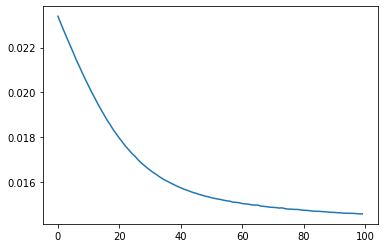

In [20]:
# View training history
plt.plot(history.history['loss'])

In [21]:
# Test model
eval_predictions = flat_list(model.predict(eval_predictors))

In [22]:
# Analyse model quality vs mean 
rmse = np.sqrt(np.mean((eval_targets.values - eval_predictions)**2))
print('LinearRegression has RMSE of {0}'.format(rmse));

avg = np.mean(train_targets)

rmse = np.sqrt(np.mean((eval_targets.values - avg)**2))
print('Using the training data mean of {0} would have has resulted in a RMSE of {1}'.format(avg, rmse));

LinearRegression has RMSE of 0.12432294598872626
Using the training data mean of 0.5124725877192983 would have has resulted in a RMSE of 0.18958985670076428


In [23]:
# Testing

test = pd.read_csv('https://raw.githubusercontent.com/MattIzon/16010269_DataAnalytics/main/DNN/DNN_day_test_set.csv')
test.drop(['date', 'gust', 'hail', 'tornado_funnel_cloud'], axis=1, inplace=True)
test_predictors = test.iloc[:,1:]
normalise_w_params(test_predictors, scale_params, norm[1:])

test_predictions = pd.DataFrame(flat_list(model.predict(test_predictors)), columns=['crime_count'])
denormalise(test_predictions, scale_params, ['crime_count'])
test_targets = test['crime_count']

results = pd.DataFrame()
results['predicted'] = test_predictions
results['actual'] = test_targets
results['error_squared'] = (results['predicted'] - results['actual']) ** 2
print(results)

print('The RMSE on the test values is {}.'.format(np.sqrt(np.mean(results.error_squared))))
print()

     predicted  actual  error_squared
0   642.455200     631     131.221612
1   681.611877     686      19.255620
2   820.900452     859    1451.575584
3   674.215210     720    2096.246999
4   749.884705     745      23.860339
5   746.259766     791    2001.688572
6   785.646973     702    6996.816035
7   682.620117     726    1881.814233
8   712.157837     741     831.870371
9   626.558350     572    2976.613512
10  740.569031     720     423.085026
11  799.991455     826     676.444409
12  624.695557     640     234.225987
13  697.392883     713     243.582092
14  685.373352     717    1000.244861
15  768.274780     751     298.418033
16  771.353882     707    4141.422107
The RMSE on the test values is 38.675410481511186.

